# Building your own chatbot and rap bot with vLLM 

This tutorial describes how to create a chatbot and rap bot and covers the following topics:

1. [Environment setup with Docker and ROCm](#env-setup)  
2. [Launching Jupyter Notebooks in a Docker container](#launch-jupyter)  
3. [Installing and configuring Hugging Face and vLLM](#hugging-face-token)  
4. [Building a basic chatbot with vLLM](#basic-chatbot)  
5. [Transforming the chatbot into a rap bot](#rap-bot)  
6. [Enhancing responses with few-shot prompting](#few-shot)
7. [Launching a GUI with Gradio: optional](#gradio-gui)

The tutorial uses vLLM for large language model (LLM) inference. vLLM optimizes text generation workloads by effectively batching requests and utilizing GPU resources, offering high throughput and low latency, which is perfect for chatbots.

---

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware

* **AMD Instinct™ GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.2**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPU(s) with relevant details, similar to the image below.

   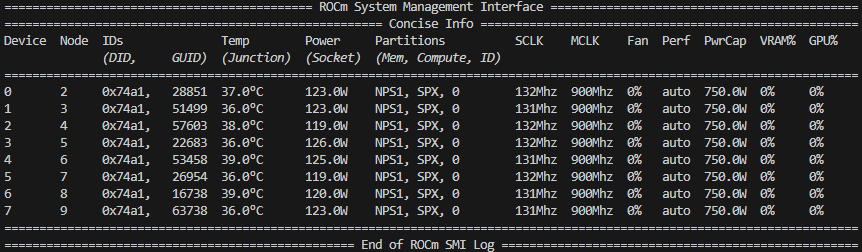


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly with:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access [Meta's Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B).

<a id="env-setup"></a>
## 1. Environment setup with Docker and ROCm

Launch the Docker container. From your host machine, run this command:

``` bash
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  --hostname=ROCm-FT \
  --env HUGGINGFACE_HUB_CACHE=/workspace \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  --entrypoint /bin/bash \
  rocm/vllm:rocm6.2_mi300_ubuntu20.04_py3.9_vllm_0.6.4
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev-docs).

<a id="launch-jupyter"></a>
## 2. Launch Jupyter Notebooks in the container

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.

<a id="hugging-face-token"></a>
## 3. Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.1-8B. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.1-8B](https://huggingface.co/meta-llama/Llama-3.1-8B). Tokens typically start with "hf_".

Run the following interactive block in your Jupyter notebook to set up the token:

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()


Verify that your token was accepted correctly:

In [ ]:
# Validate the token
try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")


<a id="basic-chatbot"></a>
## 4. Building a basic chatbot with vLLM

First, define a `Chatbot` class.  

In [ ]:
from vllm import LLM, SamplingParams
import gc
import torch
import time

class Chatbot:
    def __init__(self):
        self.history = []
        self.system_instruction = (
            "You are a helpful and professional chatbot. "
            "Keep your responses concise, friendly, and relevant."
        )
        self.llm = self.load_model()

    def load_model(self):
        model_name = "meta-llama/Meta-Llama-3-8B-Instruct"  # Adjust if using another model
        print("Loading the model. Please wait...")
        llm = LLM(model=model_name)
        print("Model loaded successfully!")
        return llm

    def construct_prompt(self, user_input):
        recent_history = self.history[-4:]
        conversation = [{"role": "system", "content": self.system_instruction}] +                        recent_history +                        [{"role": "user", "content": user_input}]
        return conversation

    def generate_response(self, conversation, max_tokens=200):
        sampling_params = SamplingParams(
            temperature=0.7,
            top_p=0.9,
            max_tokens=max_tokens
        )
        outputs = self.llm.chat(conversation, sampling_params)
        reply = outputs[0].outputs[0].text
        return reply

    def get_response(self, user_input):
        conversation = self.construct_prompt(user_input)
        bot_response = self.generate_response(conversation)
        self.history.append({"role": "user", "content": user_input})
        self.history.append({"role": "bot", "content": bot_response})
        return bot_response
    
    def cleanup(self):
        """
        Clean up resources and release GPU memory.
        """
        if hasattr(self, "llm") and self.llm:
            print("Cleaning up GPU memory...")
            del self.llm  # Delete the LLM object
            gc.collect()
            torch.cuda.empty_cache()  # Clear CUDA cache
            time.sleep(5)  # Add a 2-second wait before the final message
            print("Cleanup complete!")



### Testing the chatbot

Now test the chatbot. This code produces a text box to interact with the chatbot:

In [ ]:
chatbot = Chatbot()
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting chatbot...")
        break
    response = chatbot.get_response(user_input)
    print(f"Bot: {response}")

chatbot.cleanup()

**Note**: After the model is loaded, a text box similar to the one shown in the image below appears. Exit the chat by typing `exit` or `quit` before proceeding to the next section. 

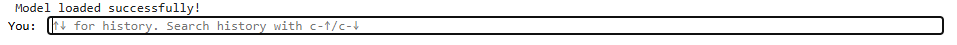

<a id="rap-bot"></a>
## 5. Transforming the chatbot into a rap bot

Now create a subclass or variation of the chatbot that instructs the model to respond in "rap style":

In [ ]:
class RapChatbot(Chatbot):
    def __init__(self):
        super().__init__()
        self.system_instruction = (
            "You are a skilled rapper chatbot. "
            "All your responses should rhyme, flow, and contain rap-like lyrics. "
            "Keep it concise yet rhythmic."
        )

### Testing the rap bot

Now test the rap bot. The following code produces a text box to interact with the rap bot:

In [ ]:
rapbot = RapChatbot()
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting chatbot...")
        break
    response = rapbot.get_response(user_input)
    print(f"Bot: {response}")

rapbot.cleanup()


**Note**: After the model is loaded, a text box similar to the one shown in the image below appears. Exit the chat by typing `exit` or `quit` before proceeding to the next section. 

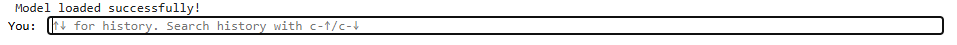

<a id="few-shot"></a>
## 6. Enhancing responses with few-shot prompting

The rap bot is almost ready. This section leverages few-shot prompting to significantly improve the bot's quality by providing examples of the expected behavior. Previously, the answers were longer and they all started with "Yo". By providing more examples, you can enhance the quality of the responses. Modify the chatbot initialization to include these examples:

In [ ]:
class EnhancedRapChatbot(RapChatbot):
    def __init__(self):
        super().__init__()
        self.system_instruction = (
            "You are a talented rapper. Every response you give should be in a short rap style, "
            "with rhymes, rhythm, and flow. Keep it engaging and fun but concise! DO NOT START your conversation with 'Yo, listen up.'"
        )
        self.few_shot_examples = [
            {"role": "user", "content": "Hi?"},
            {"role": "bot", "content": "Hey, what's good, my friend? Let's chat it up, the rhymes won't end!"},
            {"role": "user", "content": "Tell me about the weather today."},
            {"role": "bot", "content": "The sun's out bright, no clouds in sight, it's a perfect day to feel all right!"},
            {"role": "user", "content": "What's the capital of France?"},
            {"role": "bot", "content": "Paris is the name, yeah, that's the place, where the Eiffel Tower lights up the space!"},
        ]

    def construct_prompt(self, user_input):
        conversation = [
            {"role": "system", "content": self.system_instruction}
        ] + self.few_shot_examples + self.history[-4:] + [
            {"role": "user", "content": user_input}
        ]
        return conversation

### Testing the enhanced rap bot

Now test the enhanced rap bot. This code produces a text box to interact with the rap bot:

In [ ]:
enhanced_rapbot = EnhancedRapChatbot()
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting chatbot...")
        break
    response = enhanced_rapbot.get_response(user_input)
    print(f"Bot: {response}")

enhanced_rapbot.cleanup()

**Note**: After the model is loaded, a text box similar to the one shown in the image below appears. Exit the chat by typing `exit` or `quit` before proceeding to the next section. 

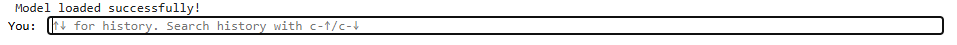

<a id="gradio-gui"></a>
## 7. Launching a GUI with Gradio (optional)

If you want to provide a graphical interface for your chatbot, use [Gradio](https://www.gradio.app/) to create an interactive web-based UI.

### Install Gradio

Inside your container or Python environment, run this command:



In [ ]:
!pip install gradio


### Create the Gradio interface

Add this code to your notebook or script:



In [ ]:
import gradio as gr
enhanced_rapbot = EnhancedRapChatbot()

# Define the function to interact with Gradio
def chat(user_input, max_tokens, temperature, top_p):
    response = enhanced_rapbot.get_response(user_input)
    return response

# Create the Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Enhanced RapBot")
    with gr.Row():
        with gr.Column(scale=0.7):
            chatbot_ui = gr.Chatbot()
            user_input = gr.Textbox(placeholder="Type your message here...")
            submit_button = gr.Button("Send")
        with gr.Column(scale=0.3):
            max_tokens = gr.Slider(50, 500, value=200, step=10, label="Max Tokens")
            temperature = gr.Slider(0.0, 1.0, value=0.7, step=0.1, label="Temperature")
            top_p = gr.Slider(0.0, 1.0, value=0.9, step=0.1, label="Top-p")

    def respond(message, chat_history, max_tokens, temperature, top_p):
        bot_response = chat(message, max_tokens, temperature, top_p)
        chat_history.append((message, bot_response))
        return chat_history, ""

    submit_button.click(respond, [user_input, chatbot_ui, max_tokens, temperature, top_p], [chatbot_ui, user_input])

# Launch the Gradio app
demo.launch(share=True)



### Run the Gradio application

Execute the code block above to launch the GUI. The interface displays in your browser, letting you interact with the chatbot using sliders to adjust parameters like `max_tokens`, `temperature`, and `top-p`.

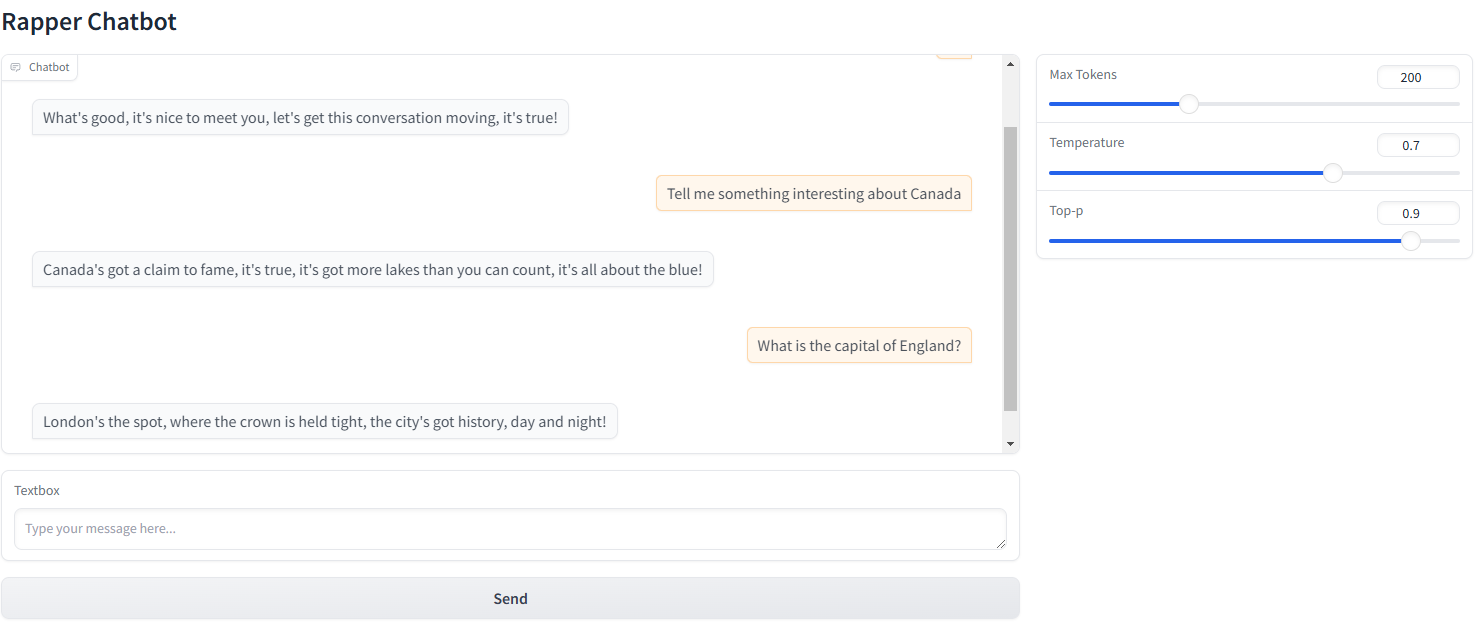


## Conclusion

In this tutorial, you accomplished the following tasks:

* Configured a Docker environment with ROCm 6.2 and vLLM.
* Built a chatbot class using vLLM.
* Extended the chatbot into a rap-style chatbot.
